In [1]:
import numpy as np
from pickle import dump, load
from numpy import array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow as tf
from os import listdir
import lightkurve as lk
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def build_rnn(X,lstm_layers,cells,output_size):
    model = Sequential()
    
    #model.add(Dense(units=cells,input_shape=(X.shape[1], X.shape[2])))
    for i in range(lstm_layers - 1):
        model.add(Bidirectional(LSTM(cells,activation='sigmoid',return_sequences=True)))
        model.add(Dropout(0.2))
        
    model.add(Bidirectional(LSTM(cells,activation='sigmoid')))
    model.add(Dropout(0.2))
    
    model.add(Dense(output_size, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.0008)
    model.compile(loss = "categorical_hinge", metrics=['categorical_accuracy'], optimizer = opt)
    return model

def build_cnn(X):
    model = Sequential()
    
    model.add(Conv1D(filters=380, kernel_size=8, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=190, kernel_size=8, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=95, kernel_size=8, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=47, kernel_size=16, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=24, kernel_size=32, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(20,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(2,activation='softmax'))

    opt = optimizers.Adam(learning_rate=3e-5)
    model.compile(loss = "categorical_hinge", metrics=['categorical_accuracy'], optimizer = opt)
    return model

def build_deep_conv_lstm(x,cells=6,filters=20,pool=2):
    input_shape = Input(shape=(x.shape[1],x.shape[2]))

    tower_1 = Conv1D(filters=filters, kernel_size=32, activation='relu', input_shape=(760, 1))(input_shape)
    tower_1 = MaxPooling1D(pool_size=pool)(tower_1)
    tower_1 = Dropout(0.5)(tower_1)

    '''tower_2 = MaxPooling1D(pool_size=2)(input_shape)
    tower_2 = Conv1D(filters=filters, kernel_size=7, activation='relu', input_shape=(760, 1))(tower_2)
    tower_2 = MaxPooling1D(pool_size=pool)(tower_2)
    tower_2 = Dropout(0.5)(tower_2)

    tower_3 = MaxPooling1D(pool_size=3)(input_shape)
    tower_3 = Conv1D(filters=filters, kernel_size=7, activation='relu', input_shape=(760, 1))(tower_3)
    tower_3 = MaxPooling1D(pool_size=pool)(tower_3)
    tower_3 = Dropout(0.5)(tower_3)'''

    tower_4 = MaxPooling1D(pool_size=4)(input_shape)
    tower_4 = Conv1D(filters=filters, kernel_size=32, activation='relu', input_shape=(760, 1))(tower_4)
    tower_4 = MaxPooling1D(pool_size=pool)(tower_4)
    tower_4 = Dropout(0.5)(tower_4)

    merged = concatenate([tower_1,tower_4],axis=1)
    #merged = Flatten()(merged)

    lstm = Bidirectional(LSTM(cells,activation='sigmoid',return_sequences=True))(merged)
    lstm = Bidirectional(LSTM(cells,activation='sigmoid'))(merged)

    out = Dense(50,activation='relu')(merged)
    out = Dropout(0.5)(out)
    out = Dense(10,activation='relu')(out)
    out = Flatten()(out)
    out = Dense(2,activation='softmax')(out)

    model = keras.Model(input_shape,out)
    opt = optimizers.Adam(learning_rate=3e-4)
    model.compile(loss = "categorical_hinge", metrics=['categorical_accuracy'], optimizer = opt)
    return model

x = np.load('E:/x_m.npy')
y = np.load('E:/y_m.npy')
x_train = x[:1906]
y_train = y[:1906]
x_test = x[1906:]
y_test = y[1906:]

In [2]:
%load_ext tensorboard

In [ ]:
model = build_rnn(x,lstm_layers=2,cells=12,output_size=2)

In [3]:
model = build_deep_conv_lstm(x)

In [ ]:
model = build_cnn(x)
model.load_weights('E:/march.h5')
model.summary()

In [4]:
import datetime
log_dir=r'/Tensorboard_ex/logs_1/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir,                     
                               histogram_freq=1)

In [5]:
history = model.fit(x_train, y_train, epochs=1, verbose=1, batch_size=64, validation_split=0, shuffle=True, callbacks=[tensorboard_callback])

 1/30 [>.............................] - ETA: 0s - loss: 1.0907 - categorical_accuracy: 0.4219WARNING:tensorflow:From C:\Users\abcmo\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 0s 10ms/step - loss: 0.9970 - categorical_accuracy: 0.4874


In [6]:
%tensorboard --logdir="\TEnsorBoard_ex\logs_1\fit"

Reusing TensorBoard on port 6006 (pid 6204), started 0:13:57 ago. (Use '!kill 6204' to kill it.)

KeyError: 'val_categorical_accuracy'

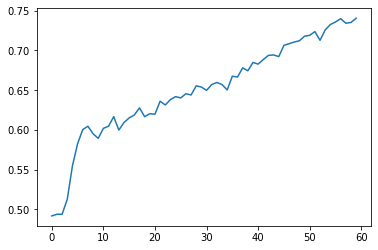

In [25]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuarcy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('accuarcy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
import seaborn as sns
def unencode(matrix):
    new_matrix = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        val = np.argmax(matrix[i])
        new_matrix[i] = classes[val]
    return new_matrix

y_test_pred = model.predict(x_test, verbose=0)


classes = [0,1]
cm = confusion_matrix(unencode(y_test),unencode(y_test_pred),labels=classes)
df = pd.DataFrame(cm).rename({0:'Blazar',1:'Star'},axis=1).rename({0:'Blazar',1:'Star'},axis=0)

figure = plt.figure(dpi=1000,figsize=(8, 8))
sns.heatmap(df, annot=True,square=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

c = 0
for i in range(len(y_test)):
    if unencode(y_test_pred)[i] == unencode(y_test)[i]:
        c = c + 1

c / len(y_test)

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5792.